<a href="https://colab.research.google.com/github/makarandmadhavi/Crash-Course-in-Statistical-Learning/blob/main/Written_Section.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How much Data do you need?

In recent years, machine learning has become increasingly popular and has been applied to a wide range of domains, from self-driving cars to healthcare. One of the critical factors that determine the success of a machine learning algorithm is the amount of data it is trained on. However, the question remains: how much data do you actually need? In this article, we will delve into the world of data and explore the optimal amount of data required for different machine learning algorithms to achieve the best results. We will also discuss the trade-offs between the amount of data and other factors such as model complexity and computational resources. The information presented in this article is inspired on the insights and research from various academic papers, including "The Impact of Big Data on Machine Learning" by Roger Grosse and "Deep Learning" by Ian Goodfellow et al.

We would take multiple very large datasets, keep all training parameters constant see how the model reacts to only having 100, 1000, 100000, million or a billion records. We would also see how the number of features in different datasets affect the model. Also plot the train-test percentage split ( 1%/99% to 99%/1% ) and its effect on the model. why 70/30 or 80/20 splits are widely used.

This article also shows how you can evaluate if you need more or less data for building your models.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', 0)
plt.style.use('ggplot')
pd.options.display.float_format = '{:.4f}'.format

import random
import gzip

import h2o
from h2o.automl import H2OAutoML


# Avazu Click-Through Rate Prediction dataset
Download the dataset from here - https://www.kaggle.com/competitions/avazu-ctr-prediction/data


We are taking 10 million random samples from 40 million dataset

Data fields
 1. id: ad identifier
    
2. click: 0/1 for non-click/click

3. hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.

4. C1 -- anonymized categorical variable

5. banner_pos

6. site_id

7. site_domain

8. site_category

9. app_id

10. app_domain

11. app_category

12. device_id

13. device_ip

14. device_model

15. device_type

16. device_conn_type

17. C14-C21 -- anonymized categorical variables

In [ ]:
num_records = 40428967
sample_size = 10000000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

data = pd.read_csv("./avazu-ctr-prediction/train.gz", parse_dates=['hour'], date_parser=parse_date,\
                      skiprows=skip_values)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 24 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                float64       
 1   click             int64         
 2   hour              datetime64[ns]
 3   C1                int64         
 4   banner_pos        int64         
 5   site_id           object        
 6   site_domain       object        
 7   site_category     object        
 8   app_id            object        
 9   app_domain        object        
 10  app_category      object        
 11  device_id         object        
 12  device_ip         object        
 13  device_model      object        
 14  device_type       int64         
 15  device_conn_type  int64         
 16  C14               int64         
 17  C15               int64         
 18  C16               int64         
 19  C17               int64         
 20  C18               int64         
 21  C19    

In [ ]:
data.describe()

,id,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,10000000.0000,10000000.0000,10000000.0000,10000000.0000,10000000.0000,10000000.0000,10000000.0000,10000000.0000,10000000.0000,10000000.0000,10000000.0000,10000000.0000,10000000.0000,10000000.0000
mean,9221961068831968256.0000,0.1693,1004.9678,0.2881,1.0154,0.3317,18843.6215,318.8841,60.0963,2112.7824,1.4325,227.0682,53239.2086,83.3889
std,5325453688856635392.0000,0.3750,1.0950,0.5066,0.5279,0.8552,4957.7988,21.2608,47.2783,609.3061,1.3263,350.8692,49955.4139,70.2908
min,1398958831653.0000,0.0000,1001.0000,0.0000,0.0000,0.0000,375.0000,120.0000,20.0000,112.0000,0.0000,33.0000,-1.0000,1.0000
25%,4609272701293149696.0000,0.0000,1005.0000,0.0000,1.0000,0.0000,16920.0000,320.0000,50.0000,1863.0000,0.0000,35.0000,-1.0000,23.0000
50%,9222120956963667968.0000,0.0000,1005.0000,0.0000,1.0000,0.0000,20346.0000,320.0000,50.0000,2323.0000,2.0000,39.0000,100049.0000,61.0000
75%,13833827928211968000.0000,0.0000,1005.0000,1.0000,1.0000,0.0000,21894.0000,320.0000,50.0000,2526.0000,3.0000,171.0000,100094.0000,101.0000
max,18446743972517787648.0000,1.0000,1012.0000,7.0000,5.0000,5.0000,24052.0000,1024.0000,1024.0000,2758.0000,3.0000,1839.0000,100248.0000,255.0000


# Evaluate size of data ( number of rows ) For a Generalized Linear model

In this section we will be using autoML to do the heavy lifting. We are not concerned with data cleaning or feature selection and will keep features to a minimum for a minimum training time, we will merely be looking at the effect of the quantity of data ( number of rows ) on the performance of the models. 

## Dropping features

For the sake of simplicity we are dropping many categorical columns as more features mean more need of memory and computational resources in turn leading to a longer training time. we will stick to simple 15 features 

In [ ]:
data.drop(columns = ["site_id",	"site_domain",	"app_id",	"app_domain",	"device_id","device_ip","device_model","app_category"],inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 16 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                float64       
 1   click             int64         
 2   hour              datetime64[ns]
 3   C1                int64         
 4   banner_pos        int64         
 5   site_category     object        
 6   device_type       int64         
 7   device_conn_type  int64         
 8   C14               int64         
 9   C15               int64         
 10  C16               int64         
 11  C17               int64         
 12  C18               int64         
 13  C19               int64         
 14  C20               int64         
 15  C21               int64         
dtypes: datetime64[ns](1), float64(1), int64(13), object(1)
memory usage: 1.2+ GB


In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment Homebrew (build 11.0.18+0); OpenJDK 64-Bit Server VM Homebrew (build 11.0.18+0, mixed mode)
  Starting server from /Users/makarandmadhavi/opt/miniconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/qv/7nzw1kfx2wg1fmvdsrhvzmsc0000gn/T/tmpe5mzjnv4
  JVM stdout: /var/folders/qv/7nzw1kfx2wg1fmvdsrhvzmsc0000gn/T/tmpe5mzjnv4/h2o_makarandmadhavi_started_from_python.out
  JVM stderr: /var/folders/qv/7nzw1kfx2wg1fmvdsrhvzmsc0000gn/T/tmpe5mzjnv4/h2o_makarandmadhavi_started_from_python.err
  Server is running at http://127.0.0.1:54325
Connecting to H2O server at http://127.0.0.1:54325 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,2 months and 15 days
H2O_cluster_name:,H2O_from_python_makarandmadhavi_wxsnu6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [ ]:
# initializing h2o dataframe
df = h2o.H2OFrame(data)
df["click"] = df["click"].asfactor()
df.describe(chunk_summary=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:10000000
Cols:16

Chunk compression summary: 
chunk_type    chunk_name                 count    count_percentage    size     size_percentage
------------  -------------------------  -------  ------------------  -------  -----------------
C0L           Constant long              40       1.03306             3.1 KB   0.00107615
CBS           Binary                     238      6.14669             1.2 MB   0.419042
CXI           Sparse Integers            104      2.68595             1.6 MB   0.549945
C1N           1-Byte Integers (w/o NAs)  1352     34.9174             53.3 MB  18.8127
C1S           1-Byte Fractions           444      11.4669             17.6 MB  6.19343
C2            2-Byte Integers            1210     31.25               95.4 MB  33.6573
C4            4-Byte Integers            242      6.25                38.2 MB  13.4574
C8D           64-bit Reals               242      6.25                76.3 MB  26.9092

Frame distribution summary: 
                 size      number_of_rows    number_of_chunks_per_column    number_of_chunks
---------------  --------  ----------------  -----------------------------  ------------------
127.0.0.1:54325  283.6 MB  1e+07             242                            3872
mean             283.6 MB  1e+07             242                            3872
min              283.6 MB  1e+07             242                            3872
max              283.6 MB  1e+07             242                            3872
stddev           0  B      0                 0                              0
total            283.6 MB  1e+07             242                            3872

,id,click,hour,C1,banner_pos,site_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
type,real,enum,time,int,int,enum,int,int,int,int,int,int,int,int,int,int
mins,1398958831653.0,,1413849600000.0,1001.0,0.0,,0.0,0.0,375.0,120.0,20.0,112.0,0.0,33.0,-1.0,1.0
mean,9.22196106883197e+18,,1414276391094.4805,1004.9678477000002,0.2880699000000001,,1.015415,0.33165959999999983,18843.621528299984,318.8840908000003,60.09627519999998,2112.7824366,1.4325247,227.0681549,53239.20856290001,83.38888020000005
maxs,1.8446743972517788e+19,,1414710000000.0,1012.0,7.0,,5.0,5.0,24052.0,1024.0,1024.0,2758.0,3.0,1839.0,100248.0,255.0
sigma,5.325453688856629e+18,,257987593.4000776,1.0950181046499152,0.5066042423616052,,0.5279003747326579,0.8551666404034003,4957.798798019174,21.26083113755551,47.278349618087354,609.3060846396974,1.326286567749789,350.8692209290103,49955.4139417851,70.29084208536915
zeros,0,,0,0,7199915,,549702,8627772,0,0,0,0,4190068,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0000640724480838e+19,0,2014-10-21 00:00:00,1005.0,0.0,28905ebd,1.0,0.0,15706.0,320.0,50.0,1722.0,0.0,35.0,100084.0,79.0
1,1.0000679056417042e+19,0,2014-10-21 00:00:00,1005.0,1.0,0569f928,1.0,0.0,18993.0,320.0,50.0,2161.0,0.0,35.0,-1.0,157.0
2,1.0000720757801103e+19,0,2014-10-21 00:00:00,1005.0,0.0,f028772b,1.0,0.0,16920.0,320.0,50.0,1899.0,0.0,431.0,100077.0,117.0


## Data splitting and training

Below are some utility functions that 
*  Split data into training and testing set according to given ratio. 
*  Train a generalized linear model (GLM). We keep all parameters including seed same for all training iterations
*  Return Performance metrics of trained model




In [ ]:
def split_train_test_ratio(data_frame,ratio):
  train, test = data_frame.split_frame(ratios=[ratio], seed=1)
  return train, test

In [ ]:
def train_autoML(training_frame):
  aml = H2OAutoML(exclude_algos= ["DRF", "GBM", "XGBoost", "DeepLearning", "StackedEnsemble"], max_runtime_secs = 10, max_models=10 , balance_classes=True, seed=111)
  aml.train(training_frame = training_frame, y = 'click')
  return aml

In [ ]:
#Getting the best model
def get_best_model_performance(aml,train,test_data,metrics_df):
  lb = aml.leaderboard
  best_model = h2o.get_model(lb[0,"model_id"])
  performance = best_model.model_performance(test_data)
  metrics_df = metrics_df.append({
    'model_id': best_model.model_id,
    'data_rows': train.nrow,
    'accuracy': np.mean(performance.accuracy()), 
    'mse': performance.mse(), 
    'rmse': performance.rmse(), 
    'logloss': performance.logloss(), 
    'auc': performance.auc(), 
    'aucpr': performance.aucpr(), 
    'gini': performance.gini(), 
    'null_deviance': performance.null_deviance(), 
    'residual_deviance': performance.residual_deviance()
    }, ignore_index=True)
  return metrics_df

In [ ]:
df_metrics = pd.DataFrame(columns=['model_id','data_rows','accuracy', 'mse', 'rmse', 'logloss', 'auc', 'aucpr', 'gini', 'null_deviance', 'residual_deviance'])
df_metrics

,model_id,data_rows,accuracy,mse,rmse,logloss,auc,aucpr,gini,null_deviance,residual_deviance


In [ ]:
train, test = split_train_test_ratio(df,0.1/100.0)
aml = train_autoML(train)
df_metrics = get_best_model_performance(aml,train,test,df_metrics)
df_metrics

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


,model_id,data_rows,accuracy,mse,rmse,logloss,auc,aucpr,gini,null_deviance,residual_deviance
0,GLM_1_AutoML_1_20230423_172837,9956,0.8929,0.1359,0.3686,0.4380,0.6344,0.2606,0.2688,9104647.3976,8750878.0232


## Training with 10%/90% splits to 90%/10% splits for 1 million data records

In [ ]:
for i in range(10,100,5):
  train, test = split_train_test_ratio(df,i/100.0)
  aml = train_autoML(train)
  df_metrics = get_best_model_performance(aml,train,test,df_metrics)
  print(df_metrics)
  h2o.remove(aml)

df_metrics

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
                          model_id data_rows  ...  null_deviance  residual_deviance
0  GLM_1_AutoML_13_20230423_173639    999689  ...   8199928.7605       8199928.7605

[1 rows x 11 columns]
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
                          model_id data_rows  ...  null_deviance  residual_deviance
0  GLM_1_AutoML_13_20230423_173639    999689  ...   8199928.7605       8199928.7605
1  GLM_1_AutoML_14_20230423_173656   1500150  ...   7745492.6646       7427021.5003

[2 rows x 11 columns]
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
                          model_id data_rows  ...  null_deviance  residual_deviance
0  GLM_1_AutoML_13_20230423_173639    999689  ...   8199928.7605       8199928.7605
1  GLM_1_AutoML_14_20230423_173656   1500150  ...   7745492.6646       7427021.50

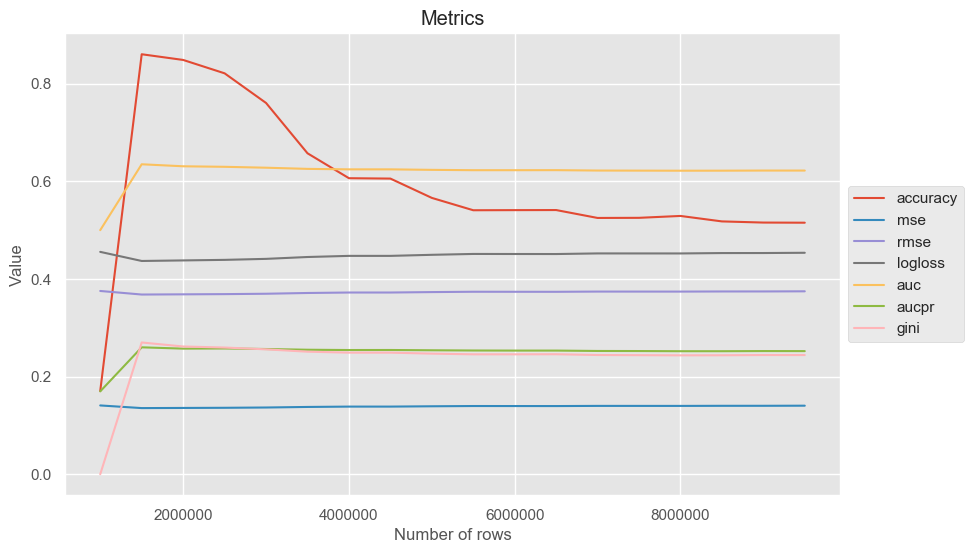

In [ ]:
df_metric = df_metrics[['accuracy','mse','rmse','logloss','auc','aucpr','gini','data_rows']]

# plot the data
ax = df_metric.plot(figsize=(10, 6), legend='reverse')

# move the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# set the axis labels and title
plt.xlabel('Number of rows')
plt.ylabel('Value')
plt.title('Metrics')

# display the plot
plt.show()

## Understanding the terms

* Accuracy: It is a metric that measures the percentage of correctly classified instances by a classifier algorithm, in a binary or multiclass classification problem.

* Mean Squared Error (MSE): It is a regression metric that calculates the average squared difference between the predicted and actual values in a continuous-valued output problem.

* Root Mean Squared Error (RMSE): It is the square root of the MSE, which gives an idea of how much the predicted values deviate from the actual values on average, in the same units as the output variable.

* Logarithmic Loss (LogLoss): It is a metric that measures the performance of a probabilistic classifier algorithm, based on the difference between the predicted and actual class probabilities, and penalizes the wrong predictions more heavily.

* Area Under the Curve (AUC): It is a metric that evaluates the performance of a binary classifier algorithm by calculating the area under the Receiver Operating Characteristic (ROC) curve, which shows the trade-off between true positive rate and false positive rate at different threshold values.

* Area Under the Precision-Recall Curve (AUCPR): It is a metric that evaluates the performance of a probabilistic classifier algorithm by calculating the area under the Precision-Recall curve, which shows the trade-off between precision and recall at different threshold values.

* Gini Coefficient: It is a metric that evaluates the performance of a binary classifier algorithm by calculating the difference between the AUC and 0.5, and multiplying it by 2, which gives a measure of the degree of class imbalance and discrimination power.

* Null Deviance: It is the deviance of a model that only includes the intercept term, which serves as a baseline for comparison with more complex models.

* Residual Deviance: It is the deviance of a model after fitting it to the data, which measures the lack of fit between the model and the data.

In [ ]:
df_metrics

,model_id,accuracy,mse,rmse,logloss,auc,aucpr,gini,null_deviance,residual_deviance
data_rows,,,,,,,,,,
999689,GLM_1_AutoML_13_20230423_173639,0.1704,0.1410,0.3754,0.4555,0.5000,0.1698,0.0000,8199928.7605,8199928.7605
1500150,GLM_1_AutoML_14_20230423_173656,0.8603,0.1355,0.3681,0.4369,0.6350,0.2600,0.2699,7745492.6646,7427021.5003
2000392,GLM_1_AutoML_15_20230423_173713,0.8487,0.1358,0.3685,0.4380,0.6308,0.2573,0.2617,7289040.3047,7007783.9827
2500438,GLM_1_AutoML_16_20230423_173731,0.8213,0.1361,0.3690,0.4392,0.6298,0.2576,0.2595,6833133.3604,6586883.3601
3000538,GLM_1_AutoML_17_20230423_173748,0.7605,0.1367,0.3698,0.4412,0.6279,0.2565,0.2559,6376820.6471,6176322.8800
3500538,GLM_1_AutoML_18_20230423_173806,0.6575,0.1379,0.3713,0.4450,0.6255,0.2551,0.2511,5921641.4874,5784661.0934
4000652,GLM_1_AutoML_19_20230423_173824,0.6064,0.1386,0.3723,0.4473,0.6246,0.2545,0.2491,5466873.7484,5367342.3310
4500677,GLM_1_AutoML_20_20230423_173842,0.6056,0.1386,0.3723,0.4473,0.6246,0.2545,0.2491,5011588.0745,4919987.6597
5000468,GLM_1_AutoML_21_20230423_173900,0.5661,0.1392,0.3731,0.4495,0.6235,0.2540,0.2471,4556508.9853,4494647.2881


### Observations
1. Apart from accuracy, there is almost no impact on mse, rmse, logloss, auc, aucpr or gini in the above graph.
2. Null Deviance and Residual Deviance linearly decreases as data size increases.

## Training with 10%/90% splits to 90%/10% splits for 100 thousand data records

In [ ]:
df_metrics = pd.DataFrame(columns=['model_id','data_rows','accuracy', 'mse', 'rmse', 'logloss', 'auc', 'aucpr', 'gini', 'null_deviance', 'residual_deviance'])

for i in range(10,100,5):
  train, test = split_train_test_ratio(df,i/1000.0)
  aml = train_autoML(train)
  df_metrics = get_best_model_performance(aml,train,test,df_metrics)
  print(df_metrics)
  h2o.remove(aml)

df_metrics

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
                          model_id data_rows  ...  null_deviance  residual_deviance
0  GLM_1_AutoML_34_20230423_175829     99969  ...   9022081.3669       8645768.5154

[1 rows x 11 columns]
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
                          model_id data_rows  ...  null_deviance  residual_deviance
0  GLM_1_AutoML_34_20230423_175829     99969  ...   9022081.3669       8645768.5154
1  GLM_1_AutoML_35_20230423_175841    149966  ...   8976350.2211       8601271.8870

[2 rows x 11 columns]
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
                          model_id data_rows  ...  null_deviance  residual_deviance
0  GLM_1_AutoML_34_20230423_175829     99969  ...   9022081.3669       8645768.5154
1  GLM_1_AutoML_35_20230423_175841    149966  ...   8976350.2211       8601271.88

,model_id,data_rows,accuracy,mse,rmse,logloss,auc,aucpr,gini,null_deviance,residual_deviance
0,GLM_1_AutoML_34_20230423_175829,99969,0.8865,0.1355,0.3681,0.4367,0.6365,0.2608,0.2731,9022081.3669,8645768.5154
1,GLM_1_AutoML_35_20230423_175841,149966,0.8615,0.1355,0.3681,0.4366,0.6358,0.2606,0.2715,8976350.2211,8601271.8870
2,GLM_1_AutoML_36_20230423_175853,199816,0.8488,0.1354,0.3680,0.4365,0.6356,0.2605,0.2712,8930316.6790,8556159.9481
3,GLM_1_AutoML_37_20230423_175907,249864,0.8627,0.1354,0.3680,0.4365,0.6365,0.2616,0.2730,8884588.1490,8511397.7332
4,GLM_1_AutoML_38_20230423_175922,299923,0.8621,0.1354,0.3680,0.4365,0.6362,0.2611,0.2724,8839091.6506,8467855.7279
5,GLM_1_AutoML_39_20230423_175935,349862,0.8779,0.1354,0.3680,0.4365,0.6365,0.2615,0.2729,8793685.4799,8424093.3569
6,GLM_1_AutoML_40_20230423_175950,399743,0.8607,0.1354,0.3680,0.4365,0.6362,0.2613,0.2725,8748080.2550,8380344.2852
7,GLM_1_AutoML_41_20230423_180004,449903,0.8604,0.1354,0.3680,0.4365,0.6364,0.2613,0.2727,8702469.2202,8336478.9036
8,GLM_1_AutoML_42_20230423_180020,499826,0.8521,0.1354,0.3680,0.4364,0.6362,0.2615,0.2725,8656694.6002,8292257.1091
9,GLM_1_AutoML_43_20230423_180036,549830,0.8691,0.1354,0.3680,0.4364,0.6364,0.2616,0.2728,8610714.0807,8248428.3174


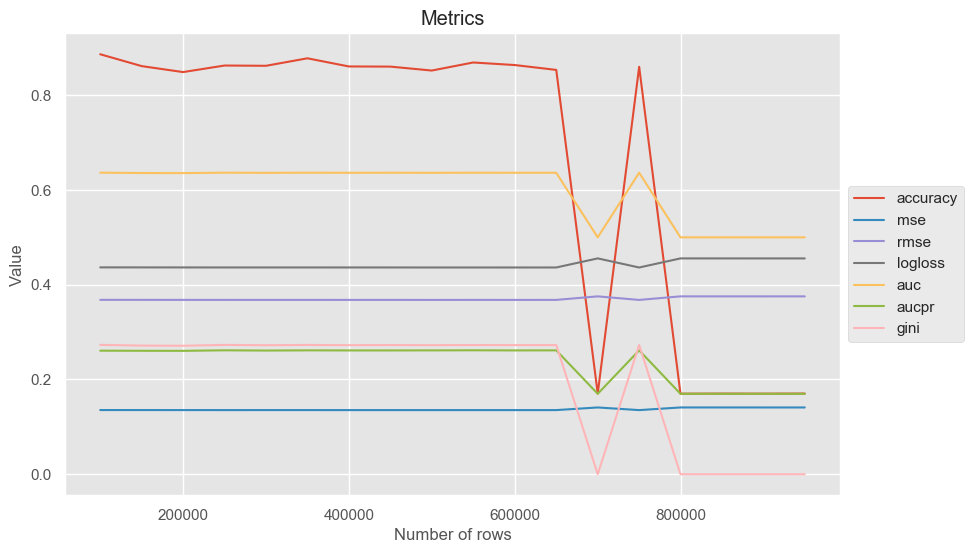

In [ ]:
df_metric = df_metrics[['accuracy','mse','rmse','logloss','auc','aucpr','gini','data_rows']].set_index('data_rows')

# plot the data
ax = df_metric.plot(figsize=(10, 6), legend='reverse')

# move the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# set the axis labels and title
plt.xlabel('Number of rows')
plt.ylabel('Value')
plt.title('Metrics')

# display the plot
plt.show()

The high variance in values between 600k and 800k is due to random seed error during training

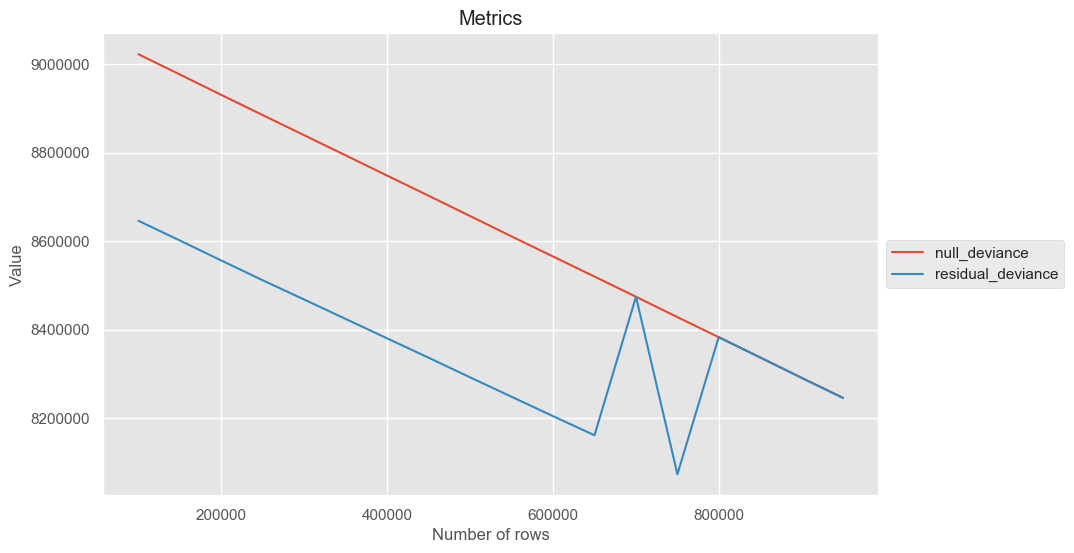

In [ ]:
df_metric = df_metrics[['null_deviance',	'residual_deviance','data_rows']].set_index('data_rows')

# plot the data
ax = df_metric.plot(figsize=(10, 6), legend='reverse')

# move the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# set the axis labels and title
plt.xlabel('Number of rows')
plt.ylabel('Value')
plt.title('Metrics')

# display the plot
plt.show()

### Observarions
1. Similar to a million data records  

## Training with 10%/90% splits to 90%/10% splits for 10 thousand data records

In [ ]:
df_metrics = pd.DataFrame(columns=['model_id','data_rows','accuracy', 'mse', 'rmse', 'logloss', 'auc', 'aucpr', 'gini', 'null_deviance', 'residual_deviance'])

for i in range(10,100,5):
  train, test = split_train_test_ratio(df,i/10000.0)
  aml = train_autoML(train)
  df_metrics = get_best_model_performance(aml,train,test,df_metrics)
  print(df_metrics)
  h2o.remove(aml)

df_metrics

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
                          model_id data_rows  ...  null_deviance  residual_deviance
0  GLM_1_AutoML_52_20230423_180946      9956  ...   9104647.3976       8750878.0232

[1 rows x 11 columns]
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
                          model_id data_rows  ...  null_deviance  residual_deviance
0  GLM_1_AutoML_52_20230423_180946      9956  ...   9104647.3976       8750878.0232
1  GLM_1_AutoML_53_20230423_181003     14989  ...   9101697.2160       8745578.6052

[2 rows x 11 columns]
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
                          model_id data_rows  ...  null_deviance  residual_deviance
0  GLM_1_AutoML_52_20230423_180946      9956  ...   9104647.3976       8750878.0232
1  GLM_1_AutoML_53_20230423_181003     14989  ...   9101697.2160       8745578.60

,model_id,data_rows,accuracy,mse,rmse,logloss,auc,aucpr,gini,null_deviance,residual_deviance
0,GLM_1_AutoML_52_20230423_180946,9956,0.8929,0.1359,0.3686,0.4380,0.6344,0.2606,0.2688,9104647.3976,8750878.0232
1,GLM_1_AutoML_53_20230423_181003,14989,0.8923,0.1359,0.3686,0.4379,0.6318,0.2592,0.2636,9101697.2160,8745578.6052
2,GLM_1_AutoML_54_20230423_181015,20000,0.8808,0.1357,0.3684,0.4375,0.6347,0.2615,0.2693,9097012.7563,8732604.3414
3,GLM_1_AutoML_55_20230423_181027,24980,0.8920,0.1358,0.3685,0.4375,0.6354,0.2611,0.2708,9091667.8530,8727899.8846
4,GLM_1_AutoML_56_20230423_181039,29979,0.8815,0.1358,0.3685,0.4377,0.6348,0.2607,0.2696,9087149.0964,8727998.6138
5,GLM_1_AutoML_57_20230423_181051,34978,0.8984,0.1357,0.3684,0.4371,0.6360,0.2606,0.2720,9082665.2020,8712355.5757
6,GLM_1_AutoML_58_20230423_181104,39991,0.8819,0.1359,0.3686,0.4382,0.6313,0.2582,0.2625,9079205.2487,8728296.9899
7,GLM_1_AutoML_59_20230423_181117,45001,0.8932,0.1356,0.3682,0.4368,0.6363,0.2624,0.2725,9072667.2060,8696986.1957
8,GLM_1_AutoML_60_20230423_181130,49953,0.9020,0.1357,0.3683,0.4371,0.6360,0.2605,0.2720,9068693.4043,8697411.3227
9,GLM_1_AutoML_61_20230423_181142,54987,0.8906,0.1356,0.3683,0.4370,0.6357,0.2603,0.2713,9064018.9884,8691339.5729


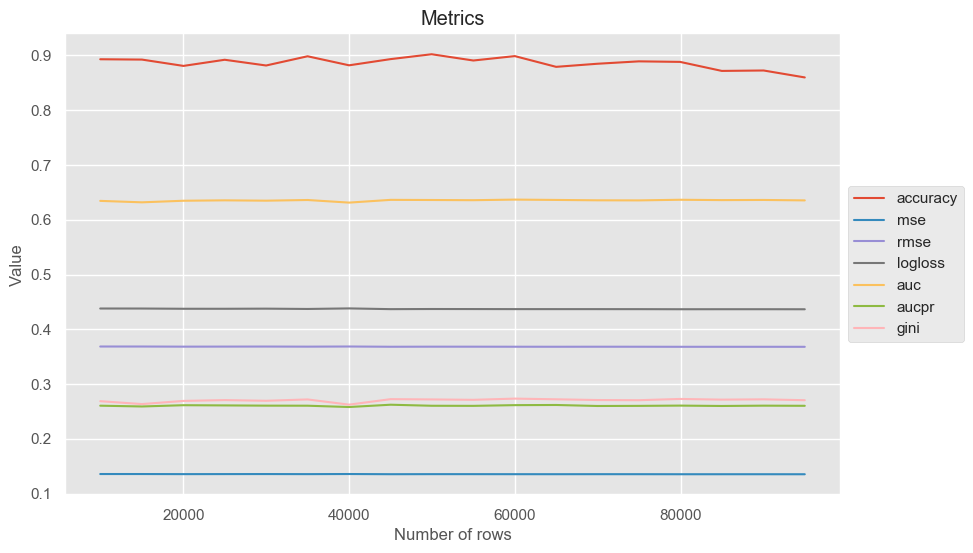

In [ ]:
df_metric = df_metrics[['accuracy','mse','rmse','logloss','auc','aucpr','gini','data_rows']].set_index('data_rows')

# plot the data
ax = df_metric.plot(figsize=(10, 6), legend='reverse')

# move the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# set the axis labels and title
plt.xlabel('Number of rows')
plt.ylabel('Value')
plt.title('Metrics')

# display the plot
plt.show()

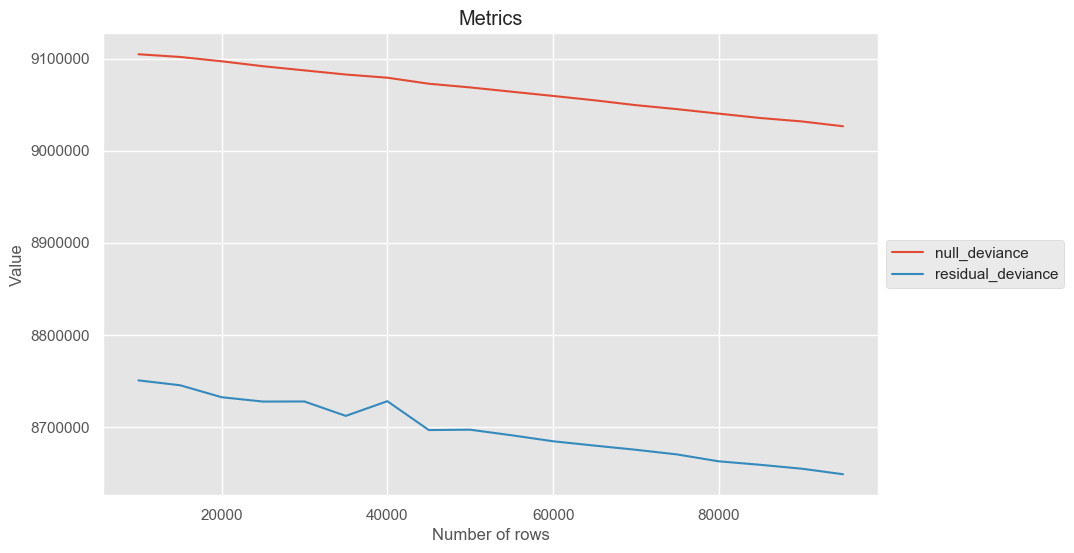

In [ ]:
df_metric = df_metrics[['null_deviance',	'residual_deviance','data_rows']].set_index('data_rows')

# plot the data
ax = df_metric.plot(figsize=(10, 6), legend='reverse')

# move the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# set the axis labels and title
plt.xlabel('Number of rows')
plt.ylabel('Value')
plt.title('Metrics')

# display the plot
plt.show()

### Observations
1. Once again we see the same trend as in 1 million and 100k record values.
2. It is interesting to note that there is a slight increase in accuracy as we go from 1 million to 10k. This is because we are keeping maximum training time constant. As more data requires more processing, the lower the amount of data the more its going to be processed. Less data = more trained = better accuracy within a specifies time frame. 
3. The models with higher quantity of data can reach a higher accuracy but would require more time for training.

Empirical studies show that the best results are obtained if we use 20-30% of the data for testing, and the remaining 70-80% of the data for training. [ [5] ](https://scholarworks.utep.edu/cs_techrep/1209/)

# Evaluate Data features ( number of columns ) For a Generalized Linear model

To evaluate the effect of amount of features we first need to know the order of importance of features in our model. h2o uses the following methods to determine feature importance in statistical learning like - 

1. Shapley values: This method calculates the contribution of each feature towards a prediction by measuring the change in the predicted value when a feature is added or removed.

2. Permutation feature importance: This method calculates the importance of each feature by randomly shuffling the values of the feature and measuring the resulting decrease in model performance.

3. Gini importance: This method calculates the importance of each feature by measuring the total reduction of the impurity measure (Gini index) achieved by splitting on that feature in all decision trees in the ensemble.



In [ ]:
num_records = 40428967
sample_size = 100000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

data = pd.read_csv("./avazu-ctr-prediction/train.gz", parse_dates=['hour'], date_parser=parse_date,\
                      skiprows=skip_values)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                100000 non-null  uint64        
 1   click             100000 non-null  int64         
 2   hour              100000 non-null  datetime64[ns]
 3   C1                100000 non-null  int64         
 4   banner_pos        100000 non-null  int64         
 5   site_id           100000 non-null  object        
 6   site_domain       100000 non-null  object        
 7   site_category     100000 non-null  object        
 8   app_id            100000 non-null  object        
 9   app_domain        100000 non-null  object        
 10  app_category      100000 non-null  object        
 11  device_id         100000 non-null  object        
 12  device_ip         100000 non-null  object        
 13  device_model      100000 non-null  object        
 14  devic

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment Homebrew (build 11.0.18+0); OpenJDK 64-Bit Server VM Homebrew (build 11.0.18+0, mixed mode)
  Starting server from /Users/makarandmadhavi/opt/miniconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/qv/7nzw1kfx2wg1fmvdsrhvzmsc0000gn/T/tmppkcd__m2
  JVM stdout: /var/folders/qv/7nzw1kfx2wg1fmvdsrhvzmsc0000gn/T/tmppkcd__m2/h2o_makarandmadhavi_started_from_python.out
  JVM stderr: /var/folders/qv/7nzw1kfx2wg1fmvdsrhvzmsc0000gn/T/tmppkcd__m2/h2o_makarandmadhavi_started_from_python.err
  Server is running at http://127.0.0.1:54327
Connecting to H2O server at http://127.0.0.1:54327 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,2 months and 15 days
H2O_cluster_name:,H2O_from_python_makarandmadhavi_qqzkrt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [ ]:
# initializing h2o dataframe
df = h2o.H2OFrame(data)
df["click"] = df["click"].asfactor()
df.describe(chunk_summary=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:100000
Cols:24

Chunk compression summary: 
chunk_type    chunk_name                 count    count_percentage    size      size_percentage
------------  -------------------------  -------  ------------------  --------  -----------------
CBS           Binary                     5        4.16667             12.6 KB   0.272971
CXI           Sparse Integers            1        0.833333            9.6 KB    0.209507
C1N           1-Byte Integers (w/o NAs)  39       32.5                761.9 KB  16.5714
C1S           1-Byte Fractions           5        4.16667             98.1 KB   2.13288
C2            2-Byte Integers            50       41.6667             1.9 MB    42.5514
C2S           2-Byte Fractions           5        4.16667             195.7 KB  4.25684
C4            4-Byte Integers            10       8.33333             781.9 KB  17.0061
C8D           64-bit Reals               5        4.16667             781.6 KB  16.9989

Frame distribution summary: 
                 size    number_of_rows    number_of_chunks_per_column    number_of_chunks
---------------  ------  ----------------  -----------------------------  ------------------
127.0.0.1:54327  4.5 MB  100000            5                              120
mean             4.5 MB  100000            5                              120
min              4.5 MB  100000            5                              120
max              4.5 MB  100000            5                              120
stddev           0  B    0                 0                              0
total            4.5 MB  100000            5                              120

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
type,real,enum,time,int,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int
mins,170054468732078.0,,1413849600000.0,1001.0,0.0,,,,,,,,,,0.0,0.0,375.0,120.0,20.0,112.0,0.0,33.0,-1.0,1.0
mean,9.236966671072889e+18,,1414276493723.998,1004.9687299999985,0.28818999999999995,,,,,,,,,,1.016790000000001,0.3337800000000004,18865.07408000007,318.90572000000043,60.173060000000085,2114.387280000003,1.4298299999999995,227.04069000000004,53147.14426000009,83.3863900000001
maxs,1.844663687144669e+19,,1414710000000.0,1012.0,7.0,,,,,,,,,,5.0,5.0,24043.0,1024.0,1024.0,2757.0,3.0,1839.0,100248.0,255.0
sigma,5.325786650462942e+18,,257814465.12186527,1.0951457348416225,0.5102931783703158,,,,,,,,,,0.5309716708160163,0.8579966626874099,4924.2733204046845,20.91713284716787,47.55816131878394,605.8481317902946,1.326858612150431,350.2770295270553,49961.35282080784,70.17213773327012
zeros,0,,0,0,72036,,,,,,,,,,5486,86204,0,0,0,0,41987,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0057181813599027e+19,0,2014-10-21 00:00:00,1010.0,1.0,85f751fd,c4e18dd6,50e219e0,b7f64446,7801e8d9,0f2161f8,71c467d1,cff69b7d,30b056c0,4.0,0.0,20366.0,320.0,50.0,2333.0,0.0,39.0,-1.0,157.0
1,1.0064955696065333e+19,0,2014-10-21 00:00:00,1005.0,0.0,ceea3181,6225315b,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,72d6f41b,84ebbcd4,1.0,0.0,18993.0,320.0,50.0,2161.0,0.0,35.0,-1.0,157.0
2,1.0134235865227405e+19,1,2014-10-21 00:00:00,1005.0,0.0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,9b845355,1f0bc64f,1.0,0.0,15701.0,320.0,50.0,1722.0,0.0,35.0,-1.0,79.0


In [ ]:
train, test = split_train_test_ratio(df,0.8)

In [ ]:
aml = H2OAutoML(exclude_algos= ["DRF", "GBM", "XGBoost", "DeepLearning", "StackedEnsemble"], max_runtime_secs = 100, max_models=10 , balance_classes=True, seed=111)
aml.train(training_frame = train, y = 'click')


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_1_20230424_101341


GLM Model: summary
    family    link    regularization               lambda_search                                                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------  ---------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------
    binomial  logit   Ridge ( lambda = 4.693E-4 )  nlambda = 30, lambda.max = 4.6929, lambda.min = 4.693E-4, lambda.1se = -1.0  101897                        61363                          73                      AutoML_1_20230424_101341_training_py_14_sid_8758

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1298092336679728
RMSE: 0.36029048511995543
LogLoss: 0.41681206493730105
AUC: 0.7069511777907419
AUCPR: 0.32515963208094306
Gini: 0.4139023555814838
Null degrees of freedom: 55890
Residual degrees of freedom: -5473
Null deviance: 50837.686639503416
Residual deviance: 46592.086242821395
AIC: 169320.0862428214

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1803022344793364
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      29587  16841  0.3627   (16841.0/46428.0)
1      3252   6211   0.3437   (3252.0/9463.0)
Total  32839  23052  0.3595   (20093.0/55891.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.180302     0.382039  228
max f2                       0.126811     0.554705  294
max f0point5                 0.270481     0.346078  133
max accuracy                 0.522448     0.83178   14
max precision                0.728815     1         0
max recall                   0.0278849    1         399
max specificity              0.728815     1         0
max absolute_mcc             0.16193      0.226059  251
max min_per_class_accuracy   0.182307     0.64451   226
max mean_per_class_accuracy  0.16193      0.650695  251
max tns                      0.728815     46428     0
max fns                      0.728815     9462      0
max fps                      0.0278849    46428     399
max tps                      0.0278849    9463      399
max tnr                      0.728815     1         0
max fnr                      0.728815     0.999894  0
max fpr                      0.0278849    1         399
max tpr                      0.0278849    1         399

Gains/Lift Table: Avg response rate: 16.93 %, avg score: 17.11 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100016                   0.45745            3.07464   3.07464            0.520572         0.491489   0.520572                    0.491489            0.0307513       0.0307513                  207.464   207.464            0.024979
2        0.0200032                   0.438096           2.66257   2.86861            0.450805         0.448607   0.485689                    0.470048            0.02663         0.0573814                  166.257   186.861            0.0449966
3        0.0300048                   0.398394           2.64144   2.79289            0.447227         0.417941   0.472868                    0.452679            0.0264187       0.0838001     

In [ ]:
aml.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_1_20230424_101341,0.704534,0.41654,0.321876,0.341104,0.359777,0.12944


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

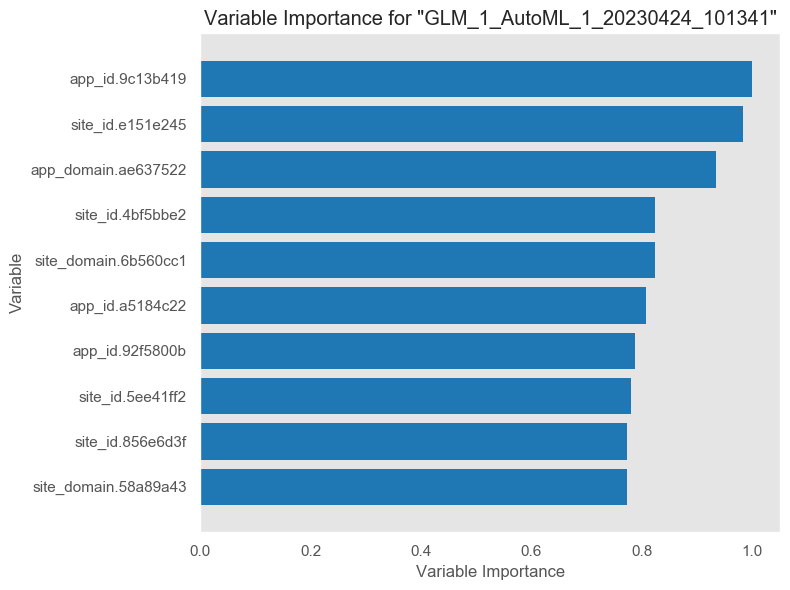

In [ ]:
explain_model = aml.explain(frame = test, figsize = (8,6),include_explanations=['varimp'])

In [ ]:
varimp = aml.leader.varimp(use_pandas=True)
varimp

,variable,relative_importance,scaled_importance,percentage
0,app_id.9c13b419,0.5448,1.0000,0.0030
1,site_id.e151e245,0.5360,0.9838,0.0030
2,app_domain.ae637522,0.5091,0.9345,0.0028
3,site_id.4bf5bbe2,0.4486,0.8234,0.0025
4,site_domain.6b560cc1,0.4486,0.8234,0.0025
...,...,...,...,...
101892,app_domain.f7f22564,0.0000,0.0000,0.0000
101893,app_domain.fd5f0ee2,0.0000,0.0000,0.0000
101894,app_domain.fd68cbd8,0.0000,0.0000,0.0000
101895,app_category.0bfbc358,0.0000,0.0000,0.0000


## Observations

1. It is important to keep most important features during training.
2. For features that have a negligible effect on the prediction can be omitted if the features to train on becomes very large.
3. In this dataset we have a lot of categorical data that has been one hot encoded. It is thus important to check if any of the categorical data can be treated as ordinals and mapped to numeric values

# Checking Distribution of test/train/validation splits

When we are splitting the data into test/train/valid we should have a equal distribution of data. 

* All numerical and categorical values should be evenly distributed, we cannot have training data with all or mostly 0s and testing with all or mostly 1s, there should be equal percentage to 1s and 0s in either sets 

In [ ]:
data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10057181813599026962,0,2014-10-21,1010,1,85f751fd,c4e18dd6,50e219e0,b7f64446,7801e8d9,0f2161f8,71c467d1,cff69b7d,30b056c0,4,0,20366,320,50,2333,0,39,-1,157
1,10064955696065332747,0,2014-10-21,1005,0,ceea3181,6225315b,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,72d6f41b,84ebbcd4,1,0,18993,320,50,2161,0,35,-1,157
2,10134235865227404270,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,9b845355,1f0bc64f,1,0,15701,320,50,1722,0,35,-1,79
3,10282029650318799854,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,967b2902,d787e91b,1,0,20362,320,50,2333,0,39,-1,157
4,10282651685226784971,0,2014-10-21,1010,1,85f751fd,c4e18dd6,50e219e0,ffc6ffd0,7801e8d9,0f2161f8,3ed59ed9,046ece0a,f07e20f8,4,0,21665,320,50,2493,3,35,-1,117


In [ ]:
from sklearn.model_selection import  train_test_split

X = data[ [ "C14",	"C15",	"C16",	"C17",	"C18",	"C19",	"C20",	"C21"]]

y = data['click']

#Spliting data into Training 76.5%, Validation set 13.5% and Test set 10%

X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)

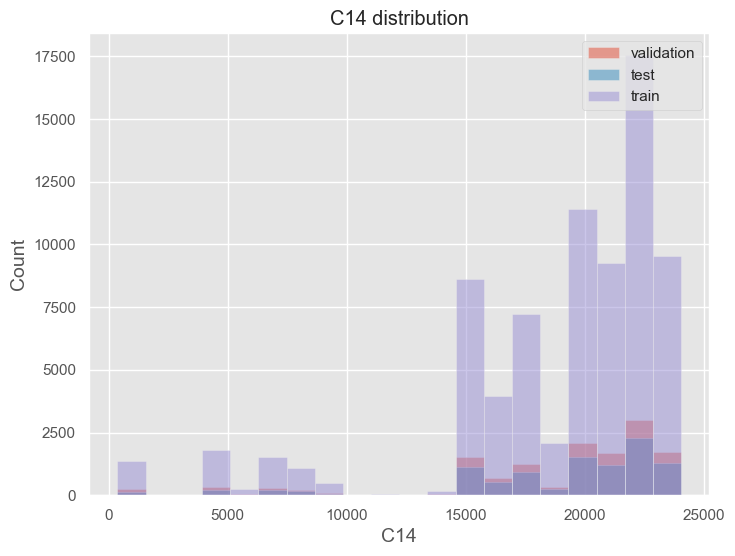

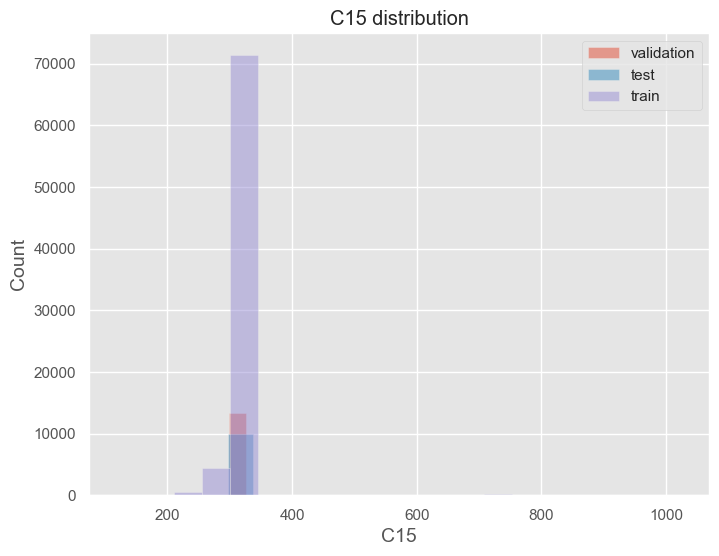

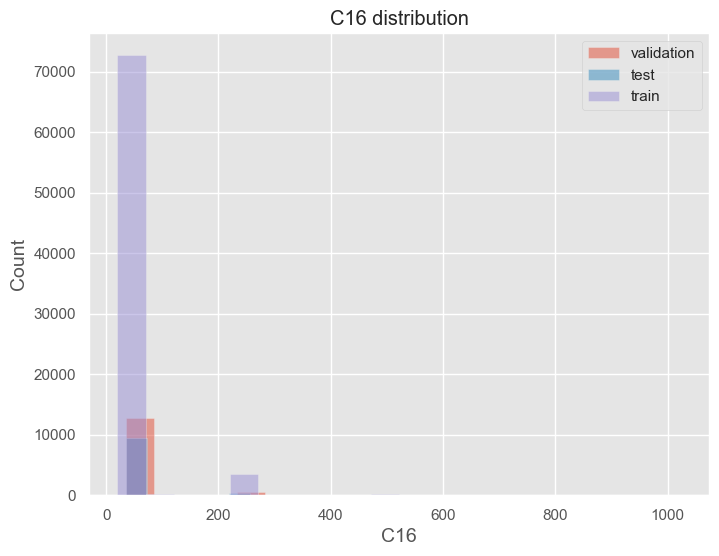

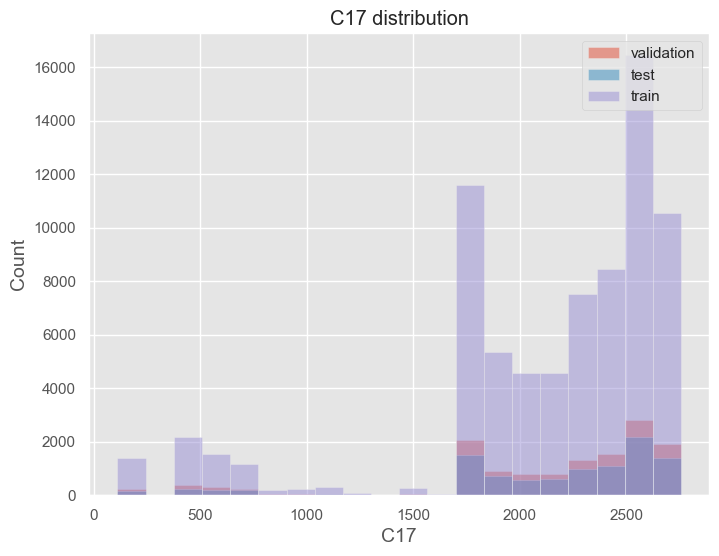

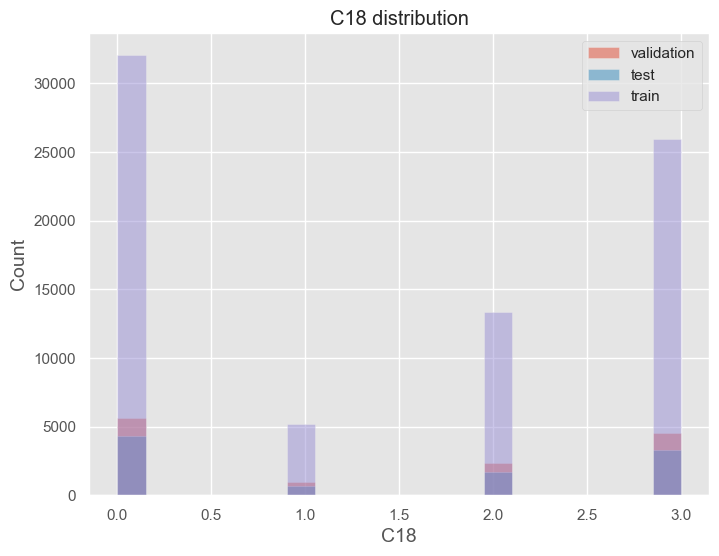

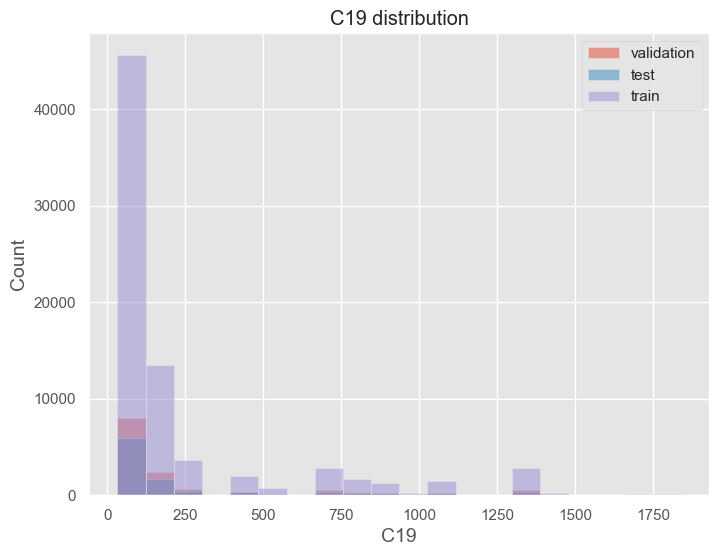

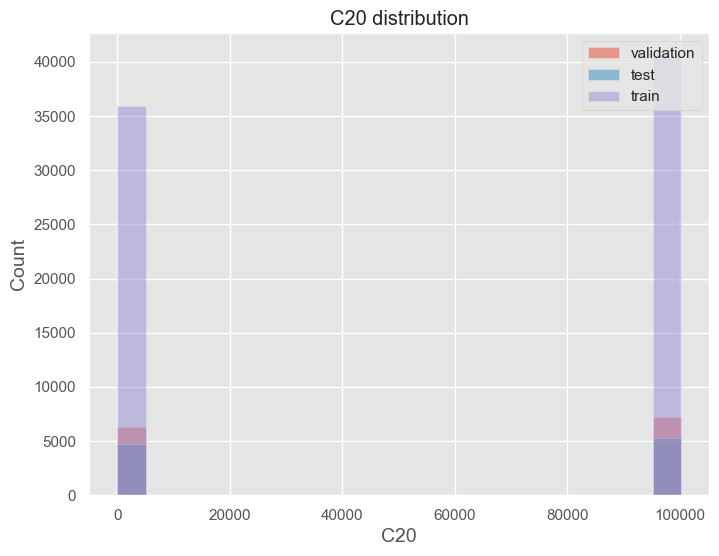

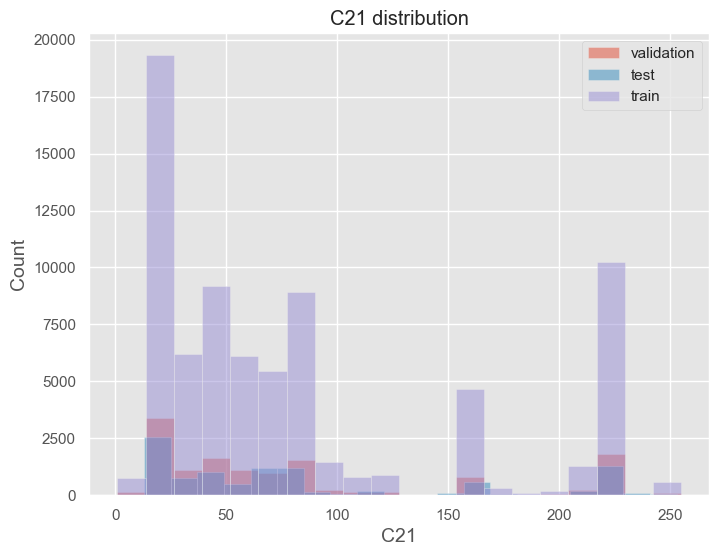

In [ ]:
# Looking the data for test, training and validation set
X_test_plot = X_test

X_val_plot = X_val

X_train_plot = X_train

# Plotting the data to see the histogram
for c in X_test_plot.columns[:]:
  plt.figure(figsize=(8,6))
  plt.hist(X_val_plot[c], bins=20, alpha=0.5, label="validation")
  plt.hist(X_test_plot[c], bins=20, alpha=0.5, label="test")
  plt.hist(X_train_plot[c], bins=20, alpha=0.5, label="train")
  plt.xlabel(c, size=14)
  plt.ylabel("Count", size=14)
  plt.legend(loc='upper right')
  plt.title("{} distribution".format(c))
  plt.show()

The above splits appear to be normally distributed

# Conclusion

In conclusion, the amount of data is a critical factor in determining the success of a machine learning algorithm. Our exploration of the optimal amount of data required for different machine learning algorithms revealed that the impact of data size is dependent on the complexity of the model and the number of features in the dataset. We also discussed the trade-offs between the amount of data and other factors such as model complexity and computational resources. Furthermore, our study showed that increasing the size of the dataset generally leads to improved model performance, but there is a point of diminishing returns. We also demonstrated how the law of large numbers applies to machine learning algorithms. Finally, we highlighted the importance of evaluating whether more or less data is required for building machine learning models. Overall, this study provides insights that can help data scientists and machine learning practitioners make informed decisions about the amount of data required for training their models.

# References

1. Grosse, R. (2016). The impact of big data on machine learning. In 2016 IEEE  International Conference on Big Data (Big Data) (pp. 4036-4037). IEEE.

2. Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.
3. ChatGPT https://chat.openai.com/
4. https://docs.h2o.ai/
5. Gholamy, Afshin; Kreinovich, Vladik; and Kosheleva, Olga, "Why 70/30 or 80/20 Relation Between Training and Testing Sets: A Pedagogical Explanation" (2018). Departmental Technical Reports (CS). 1209. https://scholarworks.utep.edu/cs_techrep/1209 

# LICENSE

All code in this note is available as open source through the MIT license.

All text and images are free to use under the Creative Commons Attribution 3.0 license. https://creativecommons.org/licenses/by/3.0/us/

MIT License

Copyright (c) 2023 Makarand Madhavi

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.